# Quantum Singular Value Transform (QSVT) for matrix inversion

This notebook shows how to solve linear systems of equations using QSVT in PennyLane. The polynomial used corresponds to the polynomial in the PennyLane tutorial https://pennylane.ai/qml/demos/tutorial_apply_qsvt/.

In [1]:
# import python libraries
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt

# Define linear system

In [2]:
A = np.array(
    [
        [0.65713691, -0.05349524, 0.08024556, -0.07242864],
        [-0.05349524, 0.65713691, -0.07242864, 0.08024556],
        [0.08024556, -0.07242864, 0.65713691, -0.05349524],
        [-0.07242864, 0.08024556, -0.05349524, 0.65713691],
    ]
)

b = np.array([1, 2, 3, 4], dtype="complex")
target_x = np.linalg.inv(A) @ b  # true solution

# Normalize states:
norm_b = np.linalg.norm(b)
b = b / norm_b

norm_x = np.linalg.norm(target_x)
normalized_x = target_x / norm_x

# Define QSVT circuit

In [3]:
def sum_even_odd_circ(x, phi, ancilla_wire, wires):
    phi1, phi2 = phi[: len(phi) // 2], phi[len(phi) // 2:]

    qml.Hadamard(wires=ancilla_wire)  # equal superposition

    # apply even and odd polynomial approx
    qml.ctrl(qml.qsvt, control=(ancilla_wire,), control_values=(0,))(x, phi1, wires=wires)
    qml.ctrl(qml.qsvt, control=(ancilla_wire,), control_values=(1,))(x, phi2, wires=wires)

    qml.Hadamard(wires=ancilla_wire)  # un-prepare superposition

def real_u(A, phi, qsvt_wires):
    qml.Hadamard(wires=qsvt_wires[0])

    qml.ctrl(sum_even_odd_circ, control=qsvt_wires[0], control_values=(0,))(A, phi, qsvt_wires[1], qsvt_wires[2:])
    qml.ctrl(qml.adjoint(sum_even_odd_circ), control=qsvt_wires[0], control_values=(1,))(A.T, phi, qsvt_wires[1], qsvt_wires[2:])

    qml.Hadamard(wires=qsvt_wires[0])

def qsvt_ls(A, phi, qsvt_wires, b):
    qml.StatePrep(b, wires=qsvt_wires[3:])
    real_u(A.T, phi, qsvt_wires)  # invert the singular values of A transpose to get A^-1

# Find phase angles to approximate $\frac{1}{x}$ with a polynomial

The polynomial is defined by the function <code> sum_even_odd_circ(x, phi, ancilla_wire, wires) </code>.

In [4]:
# Define condition number
kappa = 4

# Use PennyLane circuit optimization to determine phase angles
np.random.seed(42)  # set seed for reproducibility
phi_PL = np.random.rand(51)
s_PL = 1/(2*kappa)

samples_x = np.linspace(1 / kappa, 1, 100)

def target_func(x):
    return s_PL * (1 / x)

def loss_func(phi_PL):
    sum_square_error = 0
    for x in samples_x:
        qsvt_matrix = qml.matrix(sum_even_odd_circ, wire_order=["ancilla", 0])(x, phi_PL, ancilla_wire="ancilla", wires=[0])
        qsvt_val = qsvt_matrix[0, 0]
        sum_square_error += (np.real(qsvt_val) - target_func(x)) ** 2

    return sum_square_error / len(samples_x)

# Optimization:
cost = 1
iter = 0
opt = qml.AdagradOptimizer(0.1)

while cost > 0.5e-4:
    iter += 1
    phi_PL, cost = opt.step_and_cost(loss_func, phi_PL)

    if iter % 10 == 0 or iter == 1:
        print(f"iter: {iter}, cost: {cost}")

    if iter > 100:
        print("Iteration limit reached!")
        break

print(f"Completed Optimization! (final cost: {cost})")

# phi_PL = [ 0.39694577,  0.9997452 ,  0.6294269 ,  0.51382397,  0.12661585,
#          0.06368662,  0.05207392,  0.76748488,  0.41100678,  0.67674805,
#         -0.13309158,  0.94666788,  1.07131779,  0.08295283,  0.39285178,
#          0.102393  ,  0.30249803,  0.47688564,  0.39049023,  0.2243345 ,
#          0.59727477,  0.02979798,  0.2928709 ,  0.233082  ,  0.47847564,
#          0.83558457,  0.23441899,  0.56598652,  0.63059257,  0.09202689,
#          0.64104468,  0.18270863,  0.10175848,  0.96821947,  1.01631767,
#          0.78643135,  0.35557132,  0.09770355,  0.72862268,  0.50966534,
#          0.12205146,  0.56200074, -0.15840845,  0.98036595,  0.11804315,
#          0.71146561,  0.34005238,  0.60758267,  0.58994914,  0.21795371,
#          1.01999324]

iter: 1, cost: 0.13498775924861087
iter: 10, cost: 0.0026268606538712223
iter: 20, cost: 0.0008946918854017237
iter: 30, cost: 0.0007880079773453546
iter: 40, cost: 0.0007218765079402115
iter: 50, cost: 0.0006697389968886635
iter: 60, cost: 0.0006008050955516451
iter: 70, cost: 0.00042196118592748087
iter: 80, cost: 0.00010830354515635625
Completed Optimization! (final cost: 4.411271105503914e-05)


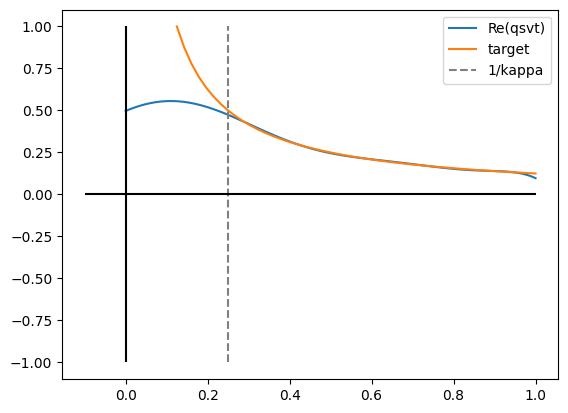

In [17]:
def plot_poly_PL(phi, s, kappa):
    x_vals = np.linspace(s, 1, 50)
    inv_x = [s * (1 / x) for x in x_vals]

    samples_x = np.linspace(0, 1, 100)
    qsvt_y_vals = [
        np.real(qml.matrix(sum_even_odd_circ, wire_order=["ancilla", 0])(x, phi, "ancilla", wires=[0])[0, 0])
        for x in samples_x
    ]

    plt.plot(samples_x, qsvt_y_vals, label="Re(qsvt)")
    plt.plot(x_vals, inv_x, label="target")

    plt.vlines(1 / kappa, -1.0, 1.0, linestyle="--", color="grey", label="1/kappa")
    plt.vlines(0.0, -1.0, 1.0, color="black")
    plt.hlines(0.0, -0.1, 1.0, color="black")

    plt.legend()
    plt.show()

plot_poly_PL(phi_PL, s_PL, kappa)

# Solve linear system using QSVT

In [18]:
ancilla_wires = [0, 1]
block_wire = [2]
solution_wires = [3, 4]

wires = ancilla_wires + block_wire + solution_wires

dev = qml.device("default.qubit", wires=wires)
@qml.qnode(dev)
def solve_ls(A, b):
    qsvt_ls(A, phi_PL, wires, b)

    return qml.state()

In [19]:
# Result by QSVT
qsvt_state = solve_ls(A, b)[:2**len(solution_wires)].real
print(qsvt_state/np.linalg.norm(qsvt_state))

[0.20803957 0.33501587 0.58320436 0.71018066]


In [20]:
# Expected result
print(normalized_x.real)

[0.20539461 0.33532754 0.58192117 0.71185409]


The solutions found by QSVT are close to the expected values (up to a constant).

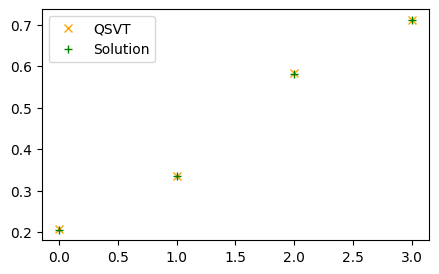

In [21]:
plt.figure(figsize=(5, 3))
plt.plot(qsvt_state/np.linalg.norm(qsvt_state), marker='x', c='orange', label="QSVT", ls="")
plt.plot(normalized_x.real, marker='+', c='green', label="Solution", ls="")
plt.legend()
plt.show()